In [3]:
import importlib

In [4]:
import Data_Prep
importlib.reload(Data_Prep)
from Data_Prep import Data_Prep, Player_IO
import Prep_Map
importlib.reload(Prep_Map)
import Output_Map
importlib.reload(Output_Map)

data_prep = Data_Prep(Prep_Map.base_prep_map, Output_Map.base_output_map)

In [5]:
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1), use_cutoff=True)

In [6]:
from sklearn.model_selection import train_test_split # type: ignore
import torch
io_train : list[Player_IO]
io_test : list[Player_IO]
io_train, io_test = train_test_split(hitter_io_list, test_size=0.25, random_state=0)

train_lengths = torch.tensor([io.length for io in io_train])
test_lengths = torch.tensor([io.length for io in io_test])

x_train_padded = torch.nn.utils.rnn.pad_sequence([io.input for io in io_train])
x_test_padded = torch.nn.utils.rnn.pad_sequence([io.input for io in io_test])
y_prospect_train_padded = torch.nn.utils.rnn.pad_sequence([io.output for io in io_train])
y_prospect_test_padded = torch.nn.utils.rnn.pad_sequence([io.output for io in io_test])
y_stats_train_padded = torch.nn.utils.rnn.pad_sequence([io.stat_output for io in io_train])
y_stats_test_padded = torch.nn.utils.rnn.pad_sequence([io.stat_output for io in io_test])
y_position_train_padded = torch.nn.utils.rnn.pad_sequence([io.position_output for io in io_train])
y_position_test_padded = torch.nn.utils.rnn.pad_sequence([io.position_output for io in io_test])
mask_prospect_train_padded = torch.nn.utils.rnn.pad_sequence([io.prospect_mask for io in io_train])
mask_prospect_test_padded = torch.nn.utils.rnn.pad_sequence([io.prospect_mask for io in io_test])
mask_level_train_padded = torch.nn.utils.rnn.pad_sequence([io.stat_level_mask for io in io_train])
mask_level_test_padded = torch.nn.utils.rnn.pad_sequence([io.stat_level_mask for io in io_test])

mask_year_train_padded = torch.nn.utils.rnn.pad_sequence([io.year_level_mask for io in io_train])
mask_year_test_padded = torch.nn.utils.rnn.pad_sequence([io.year_level_mask for io in io_test])
y_year_stats_train_padded = torch.nn.utils.rnn.pad_sequence([io.year_stat_output for io in io_train])
y_year_stats_test_padded = torch.nn.utils.rnn.pad_sequence([io.year_stat_output for io in io_test])
y_year_position_train_padded = torch.nn.utils.rnn.pad_sequence([io.year_pos_output for io in io_train])
y_year_position_test_padded = torch.nn.utils.rnn.pad_sequence([io.year_pos_output for io in io_test])

In [7]:
import Player_Dataset
importlib.reload(Player_Dataset)
from Player_Dataset import Player_Dataset

train_hitters_dataset = Player_Dataset(x_train_padded, train_lengths, y_prospect_train_padded, y_stats_train_padded, y_position_train_padded, mask_prospect_train_padded, mask_level_train_padded, mask_year_train_padded, y_year_stats_train_padded, y_year_position_train_padded)
test_hitters_dataset = Player_Dataset(x_test_padded, test_lengths, y_prospect_test_padded, y_stats_test_padded, y_position_test_padded, mask_prospect_test_padded, mask_level_test_padded, mask_year_test_padded, y_year_stats_test_padded, y_year_position_test_padded)

Train Model

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Num. Parameters: 19733
Epoch [1/1000], Train Loss: 27.6644, Test Loss: 8.0733
Epoch [2/1000], Train Loss: 6.8829, Test Loss: 6.1911
Epoch [3/1000], Train Loss: 6.4067, Test Loss: 6.1441
Epoch [4/1000], Train Loss: 6.2886, Test Loss: 6.0185
Epoch [5/1000], Train Loss: 6.1739, Test Loss: 5.9907
Epoch [6/1000], Train Loss: 6.1117, Test Loss: 5.9580
Epoch [7/1000], Train Loss: 6.0000, Test Loss: 5.8142
Epoch [8/1000], Train Loss: 5.8260, Test Loss: 5.5140
Epoch [9/1000], Train Loss: 5.5999, Test Loss: 5.3447
Epoch [10/1000], Train Loss: 5.5448, Test Loss: 5.3796
Epoch [11/1000], Train Loss: 5.4337, Test Loss: 5.3535
Epoch [12/1000], Train Loss: 5.3409, Test Loss: 5.1944
Epoch [13/1000], Train Loss: 5.2742, Test Loss: 5.3050
Epoch [14/1000], Train Loss: 5.3117, Test Loss: 5.3560
Epoch [15/1000], Train Loss: 5.1901, Test Loss: 5.1585
Epoch [16/1000], Train Loss: 5.1114, Test Loss: 5.1906
Epoch [17/1000], Train Loss: 5.1538, Test Loss: 5.4067
Epoch [18/1000], Train Loss: 5.0874, Test Loss: 5.

4.381594115243429

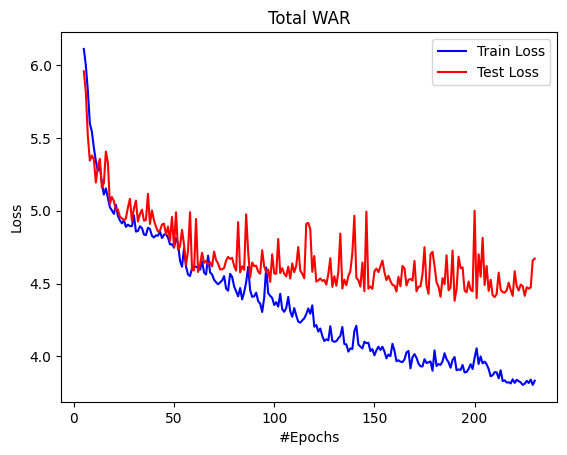

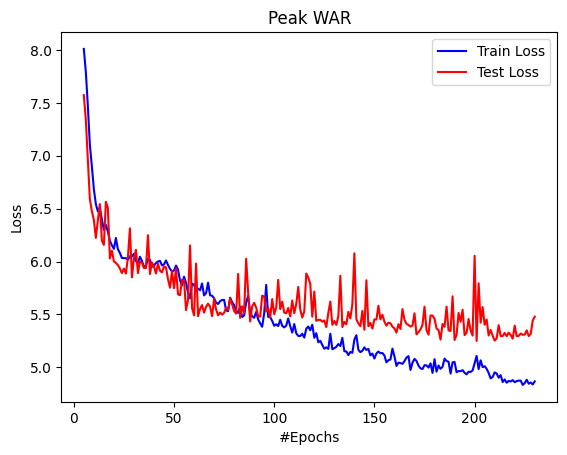

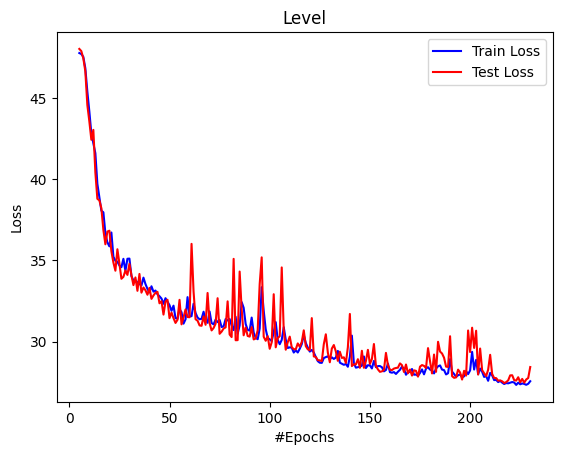

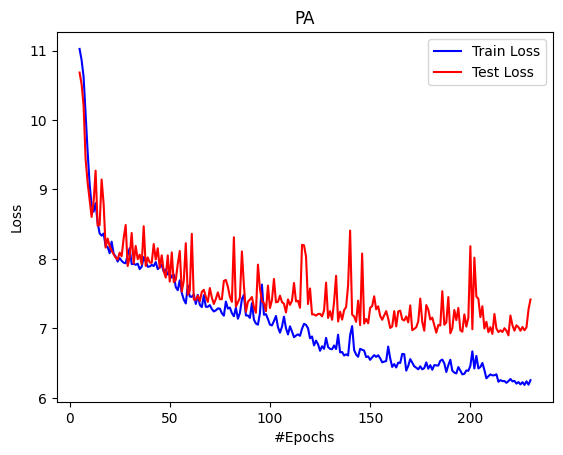

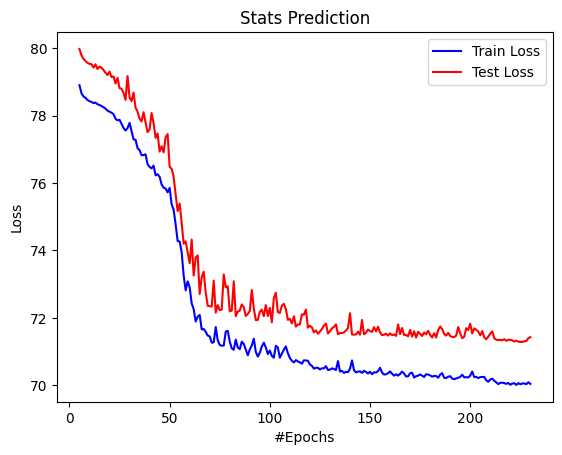

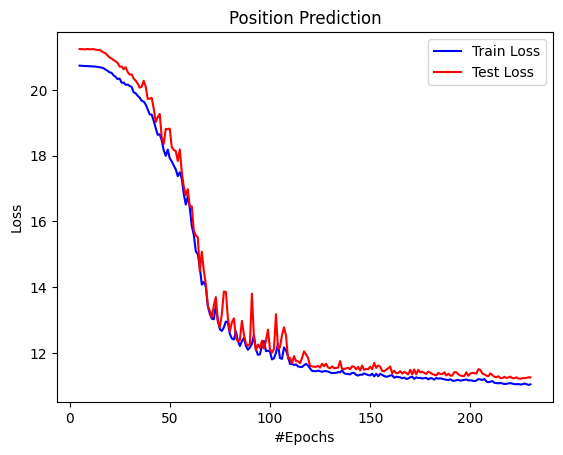

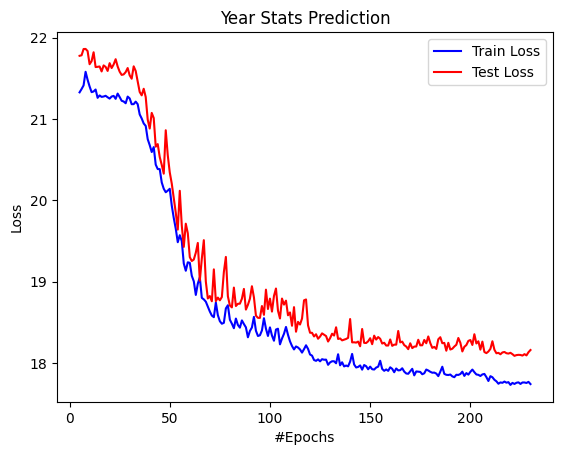

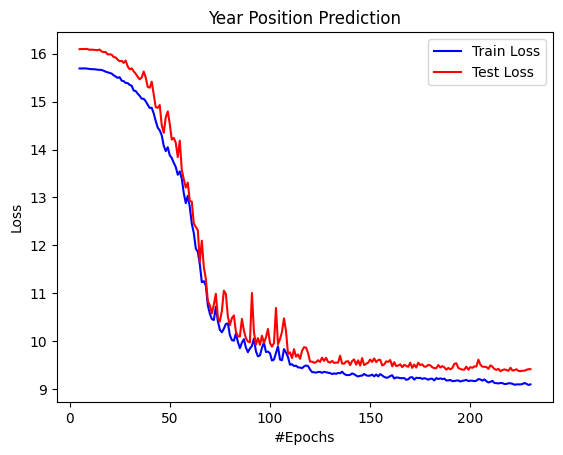

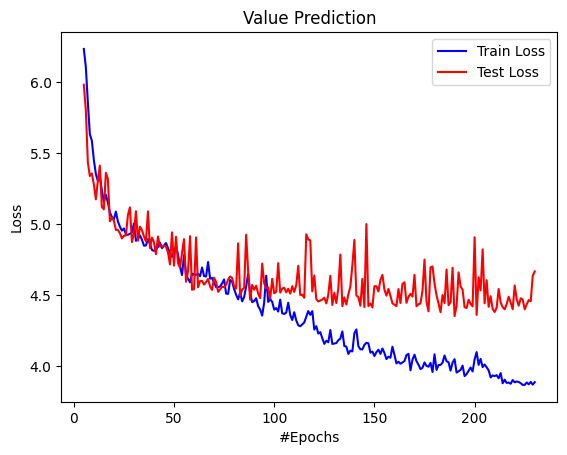

In [9]:
import Player_Model
importlib.reload(Player_Model)
from Player_Model import RNN_Model, Classification_Loss, Stats_L1_Loss
from torch.optim import lr_scheduler
import Model_Train
importlib.reload(Model_Train)
from Model_Train import trainAndGraph
from Constants import device

batch_size = 500
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Player_IO.GetMaxLength(hitter_io_list))

num_layers = 4
hidden_size = 20
network = RNN_Model(x_train_padded[0].shape[1], num_layers, hidden_size, hitting_mutators, output_map=data_prep.output_map, is_hitter=True)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = Classification_Loss
loss_function_stats = Stats_L1_Loss
loss_function_position = Player_Model.Position_Classification_Loss

num_epochs = 1000
training_generator = torch.utils.data.DataLoader(train_hitters_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_hitters_dataset, batch_size=batch_size, shuffle=False)

trainAndGraph(network, training_generator, testing_generator, len(train_hitters_dataset), len(test_hitters_dataset), loss_function, loss_function_stats, loss_function_position, optimizer, scheduler, num_epochs, logging_interval=1, early_stopping_cutoff=40, should_output=True)

Testing

In [10]:
import torch.nn as nn
import sqlite3
from tqdm import tqdm
test_db = sqlite3.connect('test.db')

In [11]:
network.load_state_dict(torch.load("no_name.pt"))
network.eval()
network = network.to(device)

In [12]:
cursor = test_db.cursor()
cursor.execute("DELETE FROM StatPred")
cursor.execute("DELETE FROM StatAct")
test_db.commit()
cursor = test_db

softmax = nn.Softmax(dim=0)

for io in tqdm(hitter_io_list):
    hitter = io.player
    input = io.input.unsqueeze(0)  
    output = io.output
    l = torch.tensor([input.shape[1]])
    twar, pwar, level, pa, value, stats, positions, year_stats, year_positions = network(input.to(device), l.to(device))
    
    for i in range(io.stat_output.size(0)):
        position_probs = softmax(positions.squeeze(0)[i,:9])
        year_position_probs = softmax(year_positions.squeeze(0)[i,:9])
        test_db.execute("INSERT INTO StatPred VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, 0, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(stats.squeeze(0)[i,:11].tolist()) + tuple(position_probs.tolist()))
        test_db.execute("INSERT INTO StatAct VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, 0, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(io.stat_output[i,:].tolist()) + tuple(io.position_output[i,:].tolist()))
        test_db.execute("INSERT INTO StatPred VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, 1, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(year_stats.squeeze(0)[i,:11].tolist()) + tuple(year_position_probs.tolist()))
        test_db.execute("INSERT INTO StatAct VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, 1, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(io.year_stat_output[i,:].tolist()) + tuple(io.year_pos_output[i,:].tolist()))
test_db.commit()

100%|██████████| 8916/8916 [02:20<00:00, 63.42it/s]
